# Try HALVA

In [ ]:
import os
import torch
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN
from llava.conversation import conv_templates
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
from PIL import Image
from matplotlib import pyplot as plt


In [ ]:
model_path="/fs01/home/anonymous/anonymous_ssd004/OUTPUTS/HALVA/anonymous/halva7b-lora/" # update your path
model_base="liuhaotian/llava-v1.5-7b"

disable_torch_init()
model_path = os.path.expanduser(model_path)
model_name = get_model_name_from_path(model_path)

print('Loading HALVA...')
tokenizer, halva, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name)

In [3]:
def inference(model, question, image_file):

    qs = DEFAULT_IMAGE_TOKEN + '\n' + question
    conv = conv_templates['v1'].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    image = Image.open(image_file).convert('RGB')
    image_tensor = process_images([image], image_processor, model.config)[0]
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()


    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            do_sample=False,
            temperature=0,
            top_p=None,
            num_beams=1,
            max_new_tokens=1024,
            use_cache=True)

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    outputs = outputs.strip()

    return outputs



# HALVA 7b

INPUT:  Describe the image in detail.
********************
OUTPUT:  The image captures a busy street at night with a car driving down the road. The street is filled with various signs, including a traffic light, which is currently showing a red light. The car is positioned in the middle of the scene, and there are other cars visible in the background.

In addition to the traffic light, there are several other traffic signs and a billboard in the area. The billboard is located on the left side of the scene, while the traffic signs are scattered throughout the image, providing guidance and information for drivers and pedestrians.
********************
Image: 


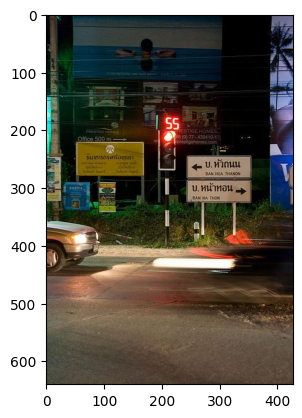

In [4]:
question="Describe the image in detail."
image_file='images/coco_000000283037.jpg'
outputs = inference(halva, question, image_file)
print('INPUT: ', question)
print('*'*20)
print('OUTPUT: ', outputs)
print('*'*20)
print('Image: ')
plt.imshow(Image.open(image_file).convert('RGB'))

INPUT:  Is there a direct contact between the dog and sea?
********************
OUTPUT:  No, there is no direct contact between the dog and the sea. The dog is running on the beach, which is a sandy area between the sea and the land.
********************
Image: 


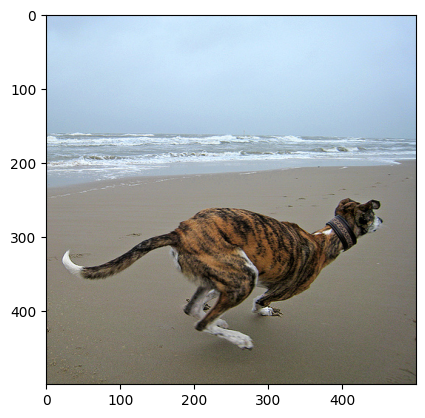

In [5]:
question="Is there a direct contact between the dog and sea?"
image_file='images/AMBER_32.jpg'
outputs = inference(halva, question, image_file)
print('INPUT: ', question)
print('*'*20)
print('OUTPUT: ', outputs)
print('*'*20)
print('Image: ')
plt.imshow(Image.open(image_file).convert('RGB'))

# LLaVA 1.5 7b

In [ ]:
print('Loading LLaVA...')
tokenizer, llava, image_processor, context_len = load_pretrained_model(model_base, None, model_base)

INPUT:  Describe the image in detail.
********************
OUTPUT:  The image captures a busy street at night with a car driving down the road. The car is positioned in the middle of the scene, and its headlights are on, illuminating the street. There are several traffic lights visible in the image, with one close to the car and others further down the street.

In addition to the car, there are two people in the scene, one standing near the left side of the image and the other closer to the center. A handbag can be seen on the ground near the person on the left. The street is lined with various signs, indicating the presence of businesses or other establishments in the area.
********************
Image: 


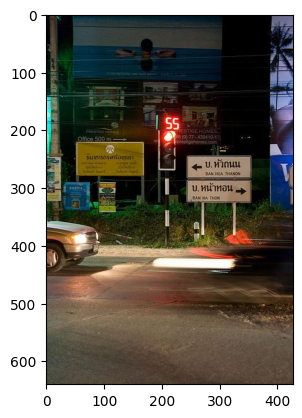

In [7]:
question="Describe the image in detail."
image_file='images/coco_000000283037.jpg'
outputs = inference(llava, question, image_file)
print('INPUT: ', question)
print('*'*20)
print('OUTPUT: ', outputs)
print('*'*20)
print('Image: ')
plt.imshow(Image.open(image_file).convert('RGB'))

INPUT:  Is there a direct contact between the dog and sea?
********************
OUTPUT:  Yes, the dog is running directly on the beach near the ocean, which means it is in close proximity to the sea.
********************
Image: 


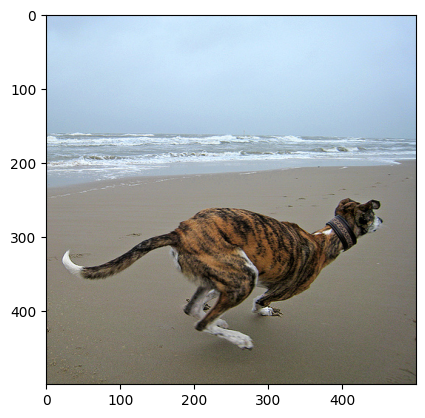

In [11]:
question="Is there a direct contact between the dog and sea?"
image_file='images/AMBER_32.jpg'
outputs = inference(llava, question, image_file)
print('INPUT: ', question)
print('*'*20)
print('OUTPUT: ', outputs)
print('*'*20)
print('Image: ')
plt.imshow(Image.open(image_file).convert('RGB'))